In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan  9 19:55:19 2019

@author: RB
"""
"""
ARRAY will be used to hold the aggregated values for each hour
arrAggregateHourlyValues
24 rows for each timeSlice of the overall period being analysed. Here 1 hour slices.
col 01: total trips - count
col 02: total passengers - summation
col 03: average passengers / trip - calculated value
col 04: store and forward flag=Y - count
col 05: store and forward flag=N - count
col 06: payment type - credit card (1) - count
col 07: payment type - cash        (2) - count
col 08: payment type - no charge   (3) - count
col 09: payment type - dispute     (4) - count
col 10: payment type - unknown     (5) - count
col 11: payment type - void        (6) - count
col 12: total fare amount - summation
col 13: average fare / trip - calculated value
col 14: total of trip distances - summations
col 15: average distance / trip - calculated value
col 16: average duration / trip - direclty from mongo

LIST to hold aggregated hourly info: each of these elements repeats for each number of time slices being considered
   which is timeSliceNumber1 to timeSliceNumber24. Each timeSlice List has 6 items. Of these 6 items, the last three are
   lists themselves for PU, DO and PU-DO combo info. See struture below--
[
  ["H1","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H2","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  similarly till H24,
]
"""
from pymongo import MongoClient
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print('\nStartTime is:',datetime.now().strftime("%c"))

client = MongoClient('localhost:27017')
dbName = client.TestNYTJune30daysDb1        # alternative way to code is:::  dbName = client['TwitterDb1']
collection = dbName.TestNYTJune30daysCol1Jun01to28   # alternative way to code is:::  collection = dbName['TwitterCol1']

# verified that accessing any one element is a string e.g. timeSlotList[4] is a string
timeSlotList=["2018-06-01 00:00:00","2018-06-02 00:00:00","2018-06-03 00:00:00","2018-06-04 00:00:00",
              "2018-06-05 00:00:00","2018-06-06 00:00:00","2018-06-07 00:00:00","2018-06-08 00:00:00",
              "2018-06-09 00:00:00","2018-06-10 00:00:00","2018-06-11 00:00:00","2018-06-12 00:00:00",
              "2018-06-13 00:00:00","2018-06-14 00:00:00","2018-06-15 00:00:00","2018-06-16 00:00:00",
              "2018-06-17 00:00:00","2018-06-18 00:00:00","2018-06-19 00:00:00","2018-06-20 00:00:00",
              "2018-06-21 00:00:00","2018-06-22 00:00:00","2018-06-23 00:00:00","2018-06-24 00:00:00",
              "2018-06-25 00:00:00"]

# =============================================================================
# Build the array arrAggregateHourlyValues[][] and populate it
# =============================================================================
arrAggregateHourlyValues = np.zeros((24,16))
for idx1 in range(0,24):
    
    timeBoundLower = timeSlotList[idx1]
    timeBoundUpper = timeSlotList[idx1 + 1]
    
    #get total number of trips
    pipeline = [ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$group": {"_id": 1, "TotalTripsCount": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalTripsCount = collection.aggregate(pipeline)
    for cursor in cursorTotalTripsCount:
        arrAggregateHourlyValues[idx1,0] = cursor["TotalTripsCount"]
    cursorTotalTripsCount.close()
    
    #get total number of passengers
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$group": {"_id": 1, "TotalPassengers": {"$sum": "$passenger_count"}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPassengers = collection.aggregate(pipeline)
    for cursor in cursorTotalPassengers:
        arrAggregateHourlyValues[idx1,1] = cursor["TotalPassengers"]
    cursorTotalPassengers.close()
    
    #get average number of passengers / trip
    arrAggregateHourlyValues[idx1,2] = arrAggregateHourlyValues[idx1,1] / arrAggregateHourlyValues[idx1,0]
    
    # total documents with Store and Forward Flag as YES
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"store_and_fwd_flag": "Y"}} , {"$group": {"_id": 1, "CountOfStoreFwdYES": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalStoreForwardYES = collection.aggregate(pipeline)
    for cursor in cursorTotalStoreForwardYES:
        arrAggregateHourlyValues[idx1,3] = cursor["CountOfStoreFwdYES"]
    cursorTotalStoreForwardYES.close()
    
    # total documents with Store and Forward Flag as NO
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"store_and_fwd_flag": "N"}} , {"$group": {"_id": 1, "CountOfStoreFwdNO": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalStoreForwardNO = collection.aggregate(pipeline)
    for cursor in cursorTotalStoreForwardNO:
        arrAggregateHourlyValues[idx1,4] = cursor["CountOfStoreFwdNO"]
    cursorTotalStoreForwardNO.close()
    
    # payment type - credit card (1)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 1}} , {"$group": {"_id": 1, "CountPaidByCreditCard": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentCreditCard = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentCreditCard:
        arrAggregateHourlyValues[idx1,5] = cursor["CountPaidByCreditCard"]
    cursorTotalPaymentCreditCard.close()
    
    # payment type - cash        (2)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 2}} , {"$group": {"_id": 1, "CountPaidByCash": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentCash = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentCash:
        arrAggregateHourlyValues[idx1,6] = cursor["CountPaidByCash"]
    cursorTotalPaymentCash.close()
    
    # payment type - no charge   (3)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 3}} , {"$group": {"_id": 1, "CountPaidByNoCharge": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentNoCharge = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentNoCharge:
        arrAggregateHourlyValues[idx1,7] = cursor["CountPaidByNoCharge"]
    cursorTotalPaymentNoCharge.close()
    
    # payment type - dispute     (4)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 4}} , {"$group": {"_id": 1, "CountPaidByDispute": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentDispute = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentDispute:
        arrAggregateHourlyValues[idx1,8] = cursor["CountPaidByDispute"]
    cursorTotalPaymentDispute.close()
    
    # payment type - unknown     (5)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 5}} , {"$group": {"_id": 1, "CountPaidByUnknown": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentUnknown = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentUnknown:
        arrAggregateHourlyValues[idx1,9] = cursor["CountPaidByUnknown"]
    cursorTotalPaymentUnknown.close()
    
    # payment type - void        (6)
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$match": {"payment_type": 6}} , {"$group": {"_id": 1, "CountPaidByVoid": {"$sum": 1}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalPaymentVoid = collection.aggregate(pipeline)
    for cursor in cursorTotalPaymentVoid:
        arrAggregateHourlyValues[idx1,10] = cursor["CountPaidByVoid"]
    cursorTotalPaymentVoid.close()
    
    #get total fare paid
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$group": {"_id": 1, "TotalOfFare": {"$sum": "$total_amount"}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalFare = collection.aggregate(pipeline)
    for cursor in cursorTotalFare:
        arrAggregateHourlyValues[idx1,11] = cursor["TotalOfFare"]
    cursorTotalFare.close()
    
    #get average fare / trip
    arrAggregateHourlyValues[idx1,12] = arrAggregateHourlyValues[idx1,11] / arrAggregateHourlyValues[idx1,0]
    
    #get total trip distances
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$group": {"_id": 1, "TotalDistance": {"$sum": "$trip_distance"}}} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTotalDistance = collection.aggregate(pipeline)
    for cursor in cursorTotalDistance:
        arrAggregateHourlyValues[idx1,13] = cursor["TotalDistance"]
    cursorTotalDistance.close()
    
    #get average distance / trip
    arrAggregateHourlyValues[idx1,14] = arrAggregateHourlyValues[idx1,13] / arrAggregateHourlyValues[idx1,0]
    
    #get average duration per trip
    pipeline=pipeline = [{"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:01", "$lt": "2018-06-01 00:00:02"}}}, {"$project": {"_id":0, "TripDurationInMins": { "$divide": [ {"$subtract": [ { "$dateFromString": {"dateString": "$tpep_dropoff_datetime"} } , { "$dateFromString": {"dateString": "$tpep_pickup_datetime"} } ]} , 60000 ] } } }, {"$group": { "_id": 1, "AvgTripDurationInMins": {"$avg": "$TripDurationInMins"} } }]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorAvgDurationPerTrip = collection.aggregate(pipeline)
    for cursor in cursorAvgDurationPerTrip:
        arrAggregateHourlyValues[idx1,15] = cursor["AvgTripDurationInMins"]
    cursorAvgDurationPerTrip.close()
    
    
# =============================================================================
# Print the arrAggregateHourlyValues array as it is
# =============================================================================
#print(arrAggregateHourlyValues)

# =============================================================================
# Print the arrAggregateHourlyValues[][] to console in readable way
# =============================================================================
print(f'\n\nAnalysis data:')
for colIdx in range(0,16):
    print('\n')
    if colIdx == 0:
        print(f'Total Trips per hour:')
    elif colIdx == 1:
        print(f'Total Passenger per hour:')
    elif colIdx == 2:
        print(f'Average Passerger/Trip per hour:')
    elif colIdx == 3:
        print(f'Count of StoreFwd=YES per hour:')
    elif colIdx == 4:
        print(f'Count of StoreFwd=NO per hour:')
    elif colIdx == 5:
        print(f'Count Payment CREDIT CARD per hour:')
    elif colIdx == 6:
        print(f'Count Payment CASH per hour:')
    elif colIdx == 7:
        print(f'Count Payment NO CHARGE per hour:')
    elif colIdx == 8:
        print(f'Count Payment DISPUTE per hour:')
    elif colIdx == 9:
        print(f'Count Payment UNKNOWN per hour:')
    elif colIdx == 10:
        print(f'Count Payment VOID per hour:')
    elif colIdx == 11:
        print(f'Total Fare Amount per hour:')
    elif colIdx == 12:
        print(f'Average Fare/Trip per hour:')
    elif colIdx == 13:
        print(f'Total Distance per hour:')
    elif colIdx == 14:
        print(f'Average Distance/Trip per hour:')
    elif colIdx == 15:
        print(f'Average Duration/Trip per hour:')
    for rowIdx in range(0,24):
        print(f'Hour%d = %.2f -- ' %(rowIdx+1, arrAggregateHourlyValues[rowIdx][colIdx]), end="", flush=True)


# =============================================================================
# # LIST BUILDING for PICK UP AND DROP OFF ANALYSIS
# =============================================================================
# =============================================================================
# List initialise start
# =============================================================================
listLocInfoAggregateHourlyValues =                                                             \
[
  ["H1","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H2","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H3","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H4","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H5","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H6","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H7","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                          
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H8","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                          
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H9","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                          
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H10","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H11","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H12","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H13","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H14","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H15","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H16","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H17","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H18","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H19","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H20","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H21","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,
  ["H22","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H23","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ] ,                                                                                                        
  ["H24","timeSliceStart-UNFILLED","timeSliceEnd-UNFILLED" ,                                         
	[ ['TopPULoc1','PULoc1-UNFILLED',0], ['TopPULoc2','PULoc2-UNFILLED',0], ['TopPULoc3','PULoc3-UNFILLED',0], ['TopPULoc4','PULoc4-UNFILLED',0], ['TopPULoc5','PULoc5-UNFILLED',0] ] ,
	[ ['TopDOLoc1','DOLoc1-UNFILLED',0], ['TopDOLoc2','DOLoc1-UNFILLED',0], ['TopDOLoc3','DOLoc3-UNFILLED',0], ['TopDOLoc4','DOLoc4-UNFILLED',0], ['TopDOLoc5','DOLoc5-UNFILLED',0] ] ,
	[ ['TopPUDOCombo1','PUDOLoc1-UNFILLED',0], ['TopPUDOCombo2','PUDOLoc2-UNFILLED',0], ['TopPUDOCombo3','PUDOLoc3-UNFILLED',0], ['TopPUDOCombo4','PUDOLoc4-UNFILLED',0], ['TopPUDOCombo5','PUDOLoc5-UNFILLED',0] ]
  ]
]
# =============================================================================
# --- x[23][3][0][1] = 'PULoc1-UNFILLED'
# --- x[23][3][0] = ['TopPULoc1', 'PULoc1-UNFILLED', 0]
# --- x[23][3] = [['TopPULoc1', 'PULoc1-UNFILLED', 0], ['TopPULoc2', 'PULoc2-UNFILLED', 0], ['TopPULoc3', 'PULoc3-UNFILLED', 0]]
# --- x[23][1] = 'timeSliceStart-UNFILLED'
# =============================================================================
# =============================================================================
# LIST Initialisation end
# =============================================================================


# =============================================================================
# print('\n\nThe location list INITIAL VALUES::')
# for idx in range(0,24):
#     print('\nTime slice number %d' %(idx + 1))
#     print(listLocInfoAggregateHourlyValues[idx][0], ' -- ' , listLocInfoAggregateHourlyValues[idx][1], ' -- ' , listLocInfoAggregateHourlyValues[idx][2])
#     print(listLocInfoAggregateHourlyValues[idx][3])
#     print(listLocInfoAggregateHourlyValues[idx][4])
#     print(listLocInfoAggregateHourlyValues[idx][5])
# =============================================================================


#print(listLocInfoAggregateHourlyValues)
# =============================================================================
# LIST POPULATION start
# =============================================================================
for idxTimeSlice in range(0,24):
    
    timeBoundLower = timeSlotList[idxTimeSlice]
    timeBoundUpper = timeSlotList[idxTimeSlice + 1]
    listLocInfoAggregateHourlyValues[idxTimeSlice][1] = timeBoundLower
    listLocInfoAggregateHourlyValues[idxTimeSlice][2] = timeBoundUpper
    # find top 5 Pick Up locations by count
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 00:00:00"}}} , {"$group":{"_id": "$PULocationID", "countPULocTrips": {"$sum": 1}}} , {"$sort": {"countPULocTrips": -1}}, {"$limit": 5} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTop3PULocsByCount = collection.aggregate(pipeline)
    idx1 = 0
    for cursor in cursorTop3PULocsByCount:
        listLocInfoAggregateHourlyValues[idxTimeSlice][3][idx1][1] = cursor["_id"]
        listLocInfoAggregateHourlyValues[idxTimeSlice][3][idx1][2] = cursor["countPULocTrips"]
        idx1 = idx1 + 1
    cursorTop3PULocsByCount.close()
    
    # find top 5 Drop Off locations by count
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-01 01:00:00"}}} , {"$group":{"_id": "$DOLocationID", "countDOLocTrips": {"$sum": 1}}} , {"$sort": {"countDOLocTrips": -1}}, {"$limit": 5} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTop3DOLocsByCount = collection.aggregate(pipeline)
    idx1 = 0
    for cursor in cursorTop3DOLocsByCount:
        listLocInfoAggregateHourlyValues[idxTimeSlice][4][idx1][1] = cursor["_id"]
        listLocInfoAggregateHourlyValues[idxTimeSlice][4][idx1][2] = cursor["countDOLocTrips"]
        idx1 = idx1 + 1
    cursorTop3DOLocsByCount.close()
    
    # find top 5 COMBINATION OF Pick Up TO Drop Off locations by count
    pipeline=[ {"$match": {"tpep_pickup_datetime": {"$gte": "2018-06-01 00:00:00", "$lt": "2018-06-02 00:00:00"}}} ,{"$project": { "PUDOCombo": { "$concat": [{"$substr":["$PULocationID", 0, -1]}, " TO " , {"$substr":["$DOLocationID", 0, -1]}]}}} ,{"$group":{"_id": "$PUDOCombo", "countPUtoDOLocTrips": {"$sum": 1}}} ,{"$sort": {"countPUtoDOLocTrips": -1}},{"$limit": 5} ]
    pipeline[0]['$match']['tpep_pickup_datetime']['$gte'] = timeBoundLower
    pipeline[0]['$match']['tpep_pickup_datetime']['$lt'] = timeBoundUpper
    cursorTop5ComboDOtoPULocsByCount = collection.aggregate(pipeline)
    idx1 = 0
    for cursor in cursorTop5ComboDOtoPULocsByCount:
        listLocInfoAggregateHourlyValues[idxTimeSlice][5][idx1][1] = cursor["_id"]
        listLocInfoAggregateHourlyValues[idxTimeSlice][5][idx1][2] = cursor["countPUtoDOLocTrips"]
        idx1 = idx1 + 1
    cursorTop5ComboDOtoPULocsByCount.close()
# =============================================================================
# LIST POPULATION end
# =============================================================================
print('\n\nThe location list AFTER populating from db::')
for idx in range(0,24):
    print('\nHour %d' %(idx + 1))
    print(listLocInfoAggregateHourlyValues[idx][0], ' -- ' , listLocInfoAggregateHourlyValues[idx][1], ' -- ' , listLocInfoAggregateHourlyValues[idx][2])
    print(listLocInfoAggregateHourlyValues[idx][3])
    print(listLocInfoAggregateHourlyValues[idx][4])
    print(listLocInfoAggregateHourlyValues[idx][5])
#print(listLocInfoAggregateHourlyValues)

# =============================================================================
# VISUALISATION PROCESSING start
# =============================================================================
#transfer data from matrix to the arrAggregateHourlyValuesAsPDF  -- a pandas data frame for plotting
arrAggregateHourlyValuesAsPDF = ({
        'c1TtlTripsPerHour':[],'c2TtlPsngrsPerHour': [], 'c3AvgPsngrsPerTripHour': [], 
        'c4CntStoreFwdYESPerHour': [], 'c5CntStoreFwdNOPerHour': [], 'c6CntPymtCreditCardPerHour': [], 
        'c7CntPymtCashPerHour': [], 'c8CntPymtNoChargePerHour': [], 'c9CntPymtDisputePerHour': [], 
        'c10CntPymtUnknownPerHour': [] , 'c11CntPymtVoidPerHour': [], 'c12TtlFarePerHour': [], 
        'c13AvgFarePerTripPerHour': [], 'c14TtlDistPerHour': [], 'c15AvgDistPerTripPerHour': [],
        'c16AvgDurationPerTripPerHour':[]
        })

for rowIdx in range(0,24):
    arrAggregateHourlyValuesAsPDF['c1TtlTripsPerHour'].append( arrAggregateHourlyValues[rowIdx][0] )
    arrAggregateHourlyValuesAsPDF['c2TtlPsngrsPerHour'].append( arrAggregateHourlyValues[rowIdx][1] )
    arrAggregateHourlyValuesAsPDF['c3AvgPsngrsPerTripHour'].append( arrAggregateHourlyValues[rowIdx][2] )
    arrAggregateHourlyValuesAsPDF['c4CntStoreFwdYESPerHour'].append( arrAggregateHourlyValues[rowIdx][3] )
    arrAggregateHourlyValuesAsPDF['c5CntStoreFwdNOPerHour'].append( arrAggregateHourlyValues[rowIdx][4] )
    arrAggregateHourlyValuesAsPDF['c6CntPymtCreditCardPerHour'].append( arrAggregateHourlyValues[rowIdx][5] )
    arrAggregateHourlyValuesAsPDF['c7CntPymtCashPerHour'].append( arrAggregateHourlyValues[rowIdx][6] )
    arrAggregateHourlyValuesAsPDF['c8CntPymtNoChargePerHour'].append( arrAggregateHourlyValues[rowIdx][7] )
    arrAggregateHourlyValuesAsPDF['c9CntPymtDisputePerHour'].append( arrAggregateHourlyValues[rowIdx][8] )
    arrAggregateHourlyValuesAsPDF['c10CntPymtUnknownPerHour'].append( arrAggregateHourlyValues[rowIdx][9] )
    arrAggregateHourlyValuesAsPDF['c11CntPymtVoidPerHour'].append( arrAggregateHourlyValues[rowIdx][10] )
    arrAggregateHourlyValuesAsPDF['c12TtlFarePerHour'].append( arrAggregateHourlyValues[rowIdx][11] )
    arrAggregateHourlyValuesAsPDF['c13AvgFarePerTripPerHour'].append( arrAggregateHourlyValues[rowIdx][12] )
    arrAggregateHourlyValuesAsPDF['c14TtlDistPerHour'].append( arrAggregateHourlyValues[rowIdx][13] )
    arrAggregateHourlyValuesAsPDF['c15AvgDistPerTripPerHour'].append( arrAggregateHourlyValues[rowIdx][14] )
    arrAggregateHourlyValuesAsPDF['c16AvgDurationPerTripPerHour'].append( arrAggregateHourlyValues[rowIdx][15] )

plotDF = pd.DataFrame(arrAggregateHourlyValuesAsPDF)

xaxisLabels1DF = pd.DataFrame({'xaxisLalels1DFKeyname':['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14',
                    'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']})


StartTime is: Thu Jan 10 00:59:19 2019


Analysis data:


Total Trips per hour:
Hour1 = 320529.00 -- Hour2 = 308393.00 -- Hour3 = 265244.00 -- Hour4 = 279353.00 -- Hour5 = 298140.00 -- Hour6 = 316295.00 -- Hour7 = 319705.00 -- Hour8 = 317536.00 -- Hour9 = 294586.00 -- Hour10 = 249781.00 -- Hour11 = 279203.00 -- Hour12 = 296397.00 -- Hour13 = 313461.00 -- Hour14 = 316543.00 -- Hour15 = 282971.00 -- Hour16 = 275941.00 -- Hour17 = 250311.00 -- Hour18 = 282087.00 -- Hour19 = 299022.00 -- Hour20 = 308577.00 -- Hour21 = 309849.00 -- Hour22 = 313110.00 -- Hour23 = 274233.00 -- Hour24 = 244864.00 -- 

Total Passenger per hour:
Hour1 = 507899.00 -- Hour2 = 509665.00 -- Hour3 = 431153.00 -- Hour4 = 436819.00 -- Hour5 = 466506.00 -- Hour6 = 495725.00 -- Hour7 = 499636.00 -- Hour8 = 504725.00 -- Hour9 = 486519.00 -- Hour10 = 408650.00 -- Hour11 = 437516.00 -- Hour12 = 465550.00 -- Hour13 = 492277.00 -- Hour14 = 497734.00 -- Hour15 = 440440.00 -- Hour16 = 453133.00 -- Hour17 = 415765.00 -- Hour18 

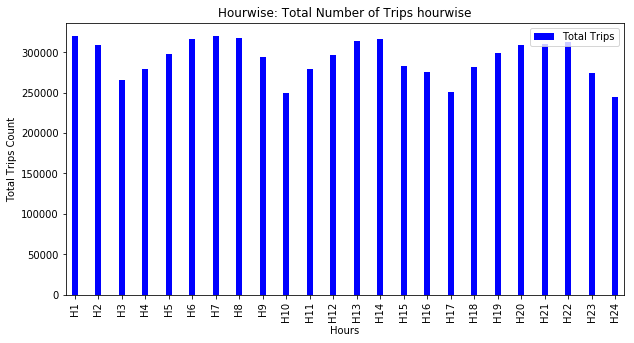

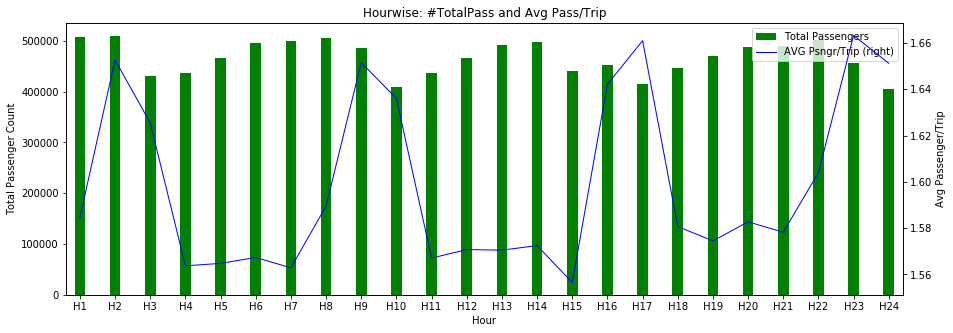

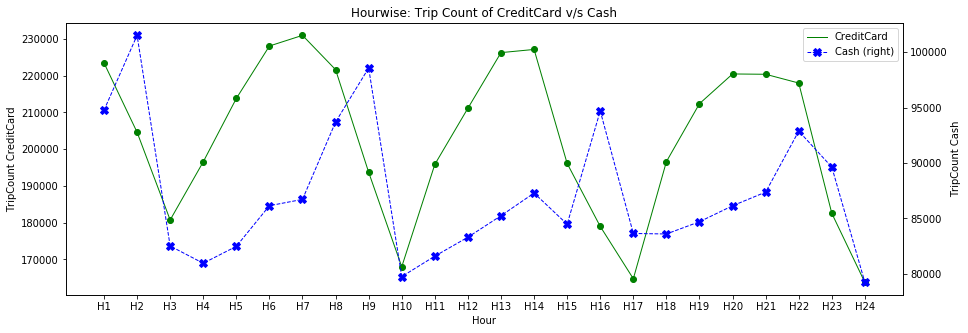

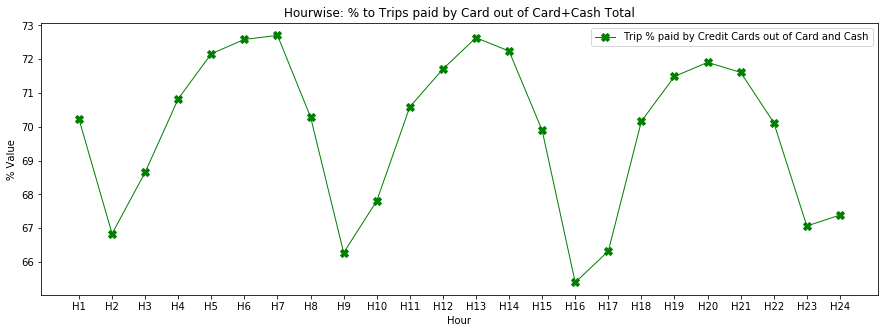

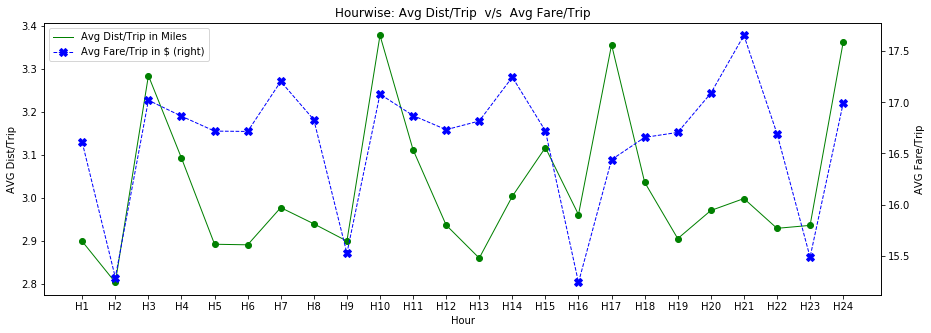

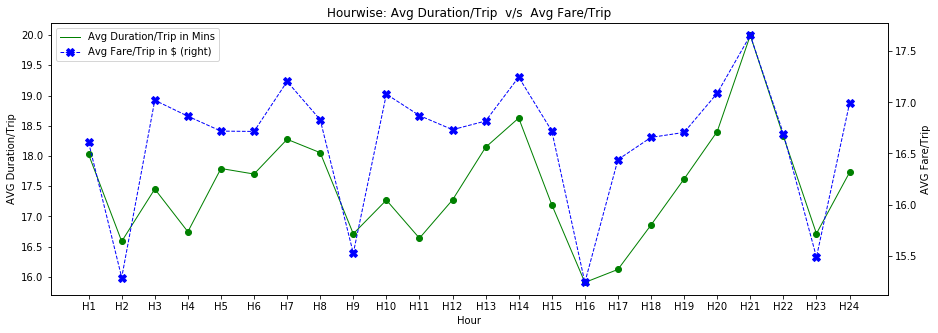

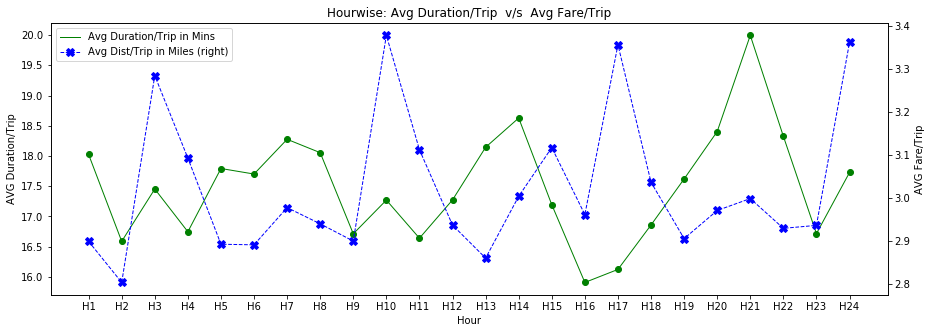

In [5]:
# Plot 1 ---- Total Trips per hour
widthFig10 = .25 # width of a bar

plotDF['c1TtlTripsPerHour'].plot(kind='bar', width = widthFig10, color='b',
                                   title='Hourwise: Total Number of Trips hourwise',
                                   figsize=(10,5),
                                   use_index=False,
                                   label = 'Total Trips',
                                   legend=True)
ax10 = plt.gca()
#ax.set_xticklabels(('H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14',
#                    'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
#                    'H24'))
ax10.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
plt.xlabel('Hours')
plt.ylabel('Total Trips Count')
plt.show()

# Plot 2 ---- Total Passengers per hour  and   Average Passgners/Trip per hour

fig20, ax20 = plt.subplots()
plotDF['c2TtlPsngrsPerHour'].plot(kind='bar', width = 0.3, figsize=(15,5), ax=ax20, color='g', label='Total Passengers',
                                  title='Hourwise: #TotalPass and Avg Pass/Trip', legend=True)
plotDF['c3AvgPsngrsPerTripHour'].plot(secondary_y=True, ax=ax20, color='b', linewidth=1.0, legend=True, label='AVG Psngr/Trip')

ax20.set_ylabel('Total Passenger Count', fontsize=10)
ax20.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax20.set_xlabel('Hour', fontsize=10)
plt.ylabel('Avg Passenger/Trip', fontsize=10, rotation=-270)
plt.show()

# Plot 3 ---- Trip Count of CreditCard v/s Cash

fig30, ax30 = plt.subplots()
plotDF['c6CntPymtCreditCardPerHour'].plot(kind='line', linewidth = 1.0, figsize=(15,5), ax=ax30, color='g', label='CreditCard',
                                  title='Hourwise: Trip Count of CreditCard v/s Cash', marker="o", use_index=False, legend=True)
plotDF['c7CntPymtCashPerHour'].plot(secondary_y=True, ax=ax30, color='b', linewidth=1.0, marker="X", ms=8, style='--',
                                    label='Cash', legend=True)

ax30.set_ylabel('TripCount CreditCard', fontsize=10)
ax30.set_xticks(np.arange(len(xaxisLabels1DF)))
ax30.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax30.set_xlabel('Hour', fontsize=10)
plt.ylabel('TripCount Cash', fontsize=10, rotation=-270)

plt.show()

# Plot 3a ---- Percetage of CreditCard Paid Trip count against total of CreditCard + Cash only

CreditCardPerAgainstCCandCashCountList = ({'CCPerOfCCandCashTotalCountDFKeyname':[]})
    
for rowIdx in range(0,24):
    CreditCardPer = arrAggregateHourlyValues[rowIdx][5] * 100  /( arrAggregateHourlyValues[rowIdx][5] + arrAggregateHourlyValues[rowIdx][6] )
    CreditCardPerAgainstCCandCashCountList['CCPerOfCCandCashTotalCountDFKeyname'].append(CreditCardPer)

plot3aDF = pd.DataFrame(CreditCardPerAgainstCCandCashCountList)

fig31, ax31 = plt.subplots()
plot3aDF['CCPerOfCCandCashTotalCountDFKeyname'].plot(kind='line', linewidth = 1.0, figsize=(15,5), ax=ax31, color='g', label='Trip % paid by Credit Cards out of Card and Cash',
                                  title='Hourwise: % to Trips paid by Card out of Card+Cash Total', marker="X", use_index=False, legend=True, ms=8)
#plotDF['c7CntPymtCashPerHour'].plot(secondary_y=True, ax=ax31, color='b', linewidth=1.0, marker="X", ms=8, style='--',
#                                    label='Cash', legend=True)

ax31.set_ylabel('% Value', fontsize=10)
ax31.set_xticks(np.arange(len(xaxisLabels1DF)))
ax31.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax31.set_xlabel('Hour', fontsize=10)
#plt.ylabel('TripCount Cash', fontsize=10, rotation=-270)

plt.show()

# Plot 4 ---- Avg Trip Distance v/s Avg Trip Fare
# Plot 4a ---- Avg Trip Duration v/s Avg Trip Fare
# Plot 4b ---- Avg Trip Duration v/s Avg Trip Dist
# =============================================================================
# Yellow Taxi Fare info: https://www1.nyc.gov/nyc-resources/service/1271/yellow-taxi-fares
# Upon entering the taxi, you will be charged the standard City fare rate of $3.30, which includes a 50-cent State surcharge and
# a 30-cent Improvement surcharge.
# Additional charges also apply:
# -- 50 cents for every fifth of a mile
# -- 50 cents for every minute the taxi traveled less than 12 miles per hour
# -- 50 cents night surcharge for travel from 8 PM to 6 AM
# -- $1 for travel from 4 PM to 8 PM on weekdays only
# -- Travel to local airports and trips outside the City are charged different rates.
# -- NO extra charge for payment by credit or debit cards
# =============================================================================

# for distance v/s fare

fig40, ax40 = plt.subplots()
plotDF['c15AvgDistPerTripPerHour'].plot(kind='line', linewidth = 1.0, figsize=(15,5), ax=ax40, color='g', label='Avg Dist/Trip in Miles',
                                  title='Hourwise: Avg Dist/Trip  v/s  Avg Fare/Trip', marker="o", use_index=False, legend=True)
plotDF['c13AvgFarePerTripPerHour'].plot(secondary_y=True, ax=ax40, color='b', linewidth=1.0, marker="X", ms=8, style='--',
                                    label='Avg Fare/Trip in $', legend=True)

ax40.set_ylabel('AVG Dist/Trip', fontsize=10)
ax40.set_xticks(np.arange(len(xaxisLabels1DF)))
ax40.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax40.set_xlabel('Hour', fontsize=10)
plt.ylabel('AVG Fare/Trip', fontsize=10, rotation=-270)
# avg dist max/min = 1.67    avg fare max/min = 1.33
plt.show()

# for duration v/s fare

fig41, ax41 = plt.subplots()
plotDF['c16AvgDurationPerTripPerHour'].plot(kind='line', linewidth = 1.0, figsize=(15,5), ax=ax41, color='g', label='Avg Duration/Trip in Mins',
                                  title='Hourwise: Avg Duration/Trip  v/s  Avg Fare/Trip', marker="o", use_index=False, legend=True)
plotDF['c13AvgFarePerTripPerHour'].plot(secondary_y=True, ax=ax41, color='b', linewidth=1.0, marker="X", ms=8, style='--',
                                    label='Avg Fare/Trip in $', legend=True)

ax41.set_ylabel('AVG Duration/Trip', fontsize=10)
ax41.set_xticks(np.arange(len(xaxisLabels1DF)))
ax41.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax41.set_xlabel('Hour', fontsize=10)
plt.ylabel('AVG Fare/Trip', fontsize=10, rotation=-270)
plt.show()


# for duration v/s distance

fig42, ax42 = plt.subplots()
plotDF['c16AvgDurationPerTripPerHour'].plot(kind='line', linewidth = 1.0, figsize=(15,5), ax=ax42, color='g', label='Avg Duration/Trip in Mins',
                                  title='Hourwise: Avg Duration/Trip  v/s  Avg Fare/Trip', marker="o", use_index=False, legend=True)
plotDF['c15AvgDistPerTripPerHour'].plot(secondary_y=True, ax=ax42, color='b', linewidth=1.0, marker="X", ms=8, style='--',
                                    label='Avg Dist/Trip in Miles', legend=True)

ax42.set_ylabel('AVG Duration/Trip', fontsize=10)
ax42.set_xticks(np.arange(len(xaxisLabels1DF)))
ax42.set_xticklabels(xaxisLabels1DF['xaxisLalels1DFKeyname'])
ax42.set_xlabel('Hour', fontsize=10)
plt.ylabel('AVG Fare/Trip', fontsize=10, rotation=-270)
plt.show()

In [8]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 0

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1878 trips
PULoc 237 to DOLoc 236 = 2090 trips
PULoc 236 to DOLoc 237 = 1764 trips
PULoc 237 to DOLoc 237 = 1471 trips
PULoc 264 to DOLoc 264 = 3276 trips


In [9]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 1

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1146 trips
PULoc 237 to DOLoc 236 = 1415 trips
PULoc 236 to DOLoc 237 = 1232 trips
PULoc 237 to DOLoc 237 = 1081 trips
PULoc 264 to DOLoc 264 = 3495 trips


In [10]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 2

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1001 trips
PULoc 237 to DOLoc 236 = 1071 trips
PULoc 236 to DOLoc 237 = 1058 trips
PULoc 239 to DOLoc 238 = 893 trips
PULoc 264 to DOLoc 264 = 3033 trips


In [11]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 3

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1652 trips
PULoc 237 to DOLoc 236 = 2116 trips
PULoc 236 to DOLoc 237 = 1755 trips
PULoc 237 to DOLoc 237 = 1510 trips
PULoc 264 to DOLoc 264 = 3075 trips


In [12]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 4

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1801 trips
PULoc 237 to DOLoc 236 = 2396 trips
PULoc 236 to DOLoc 237 = 1981 trips
PULoc 237 to DOLoc 237 = 1767 trips
PULoc 264 to DOLoc 264 = 3357 trips


In [13]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 5

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1838 trips
PULoc 237 to DOLoc 236 = 2344 trips
PULoc 236 to DOLoc 237 = 1995 trips
PULoc 237 to DOLoc 237 = 1915 trips
PULoc 264 to DOLoc 264 = 3755 trips


In [14]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 6

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1817 trips
PULoc 237 to DOLoc 236 = 2369 trips
PULoc 236 to DOLoc 237 = 1939 trips
PULoc 237 to DOLoc 237 = 1891 trips
PULoc 264 to DOLoc 264 = 3703 trips


In [15]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 7

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1665 trips
PULoc 237 to DOLoc 236 = 2027 trips
PULoc 236 to DOLoc 237 = 1714 trips
PULoc 237 to DOLoc 237 = 1503 trips
PULoc 264 to DOLoc 264 = 3315 trips


In [16]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 8

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 888 trips
PULoc 237 to DOLoc 236 = 1242 trips
PULoc 236 to DOLoc 237 = 1130 trips
PULoc 237 to DOLoc 237 = 966 trips
PULoc 264 to DOLoc 264 = 3515 trips


In [17]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 9

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 239 to DOLoc 142 = 754 trips
PULoc 236 to DOLoc 236 = 845 trips
PULoc 237 to DOLoc 236 = 892 trips
PULoc 236 to DOLoc 237 = 819 trips
PULoc 264 to DOLoc 264 = 2929 trips


In [18]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 10

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1423 trips
PULoc 237 to DOLoc 236 = 1948 trips
PULoc 236 to DOLoc 237 = 1648 trips
PULoc 237 to DOLoc 237 = 1382 trips
PULoc 264 to DOLoc 264 = 3090 trips


In [19]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 11

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1674 trips
PULoc 237 to DOLoc 236 = 2205 trips
PULoc 236 to DOLoc 237 = 1873 trips
PULoc 237 to DOLoc 237 = 1686 trips
PULoc 264 to DOLoc 264 = 3237 trips


In [20]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 12

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1687 trips
PULoc 237 to DOLoc 236 = 2259 trips
PULoc 236 to DOLoc 237 = 1726 trips
PULoc 237 to DOLoc 237 = 1694 trips
PULoc 264 to DOLoc 264 = 2949 trips


In [21]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 13

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1679 trips
PULoc 237 to DOLoc 236 = 2165 trips
PULoc 236 to DOLoc 237 = 1793 trips
PULoc 237 to DOLoc 237 = 1637 trips
PULoc 264 to DOLoc 264 = 3377 trips


In [22]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 14

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1209 trips
PULoc 237 to DOLoc 236 = 1480 trips
PULoc 236 to DOLoc 237 = 1224 trips
PULoc 237 to DOLoc 237 = 1190 trips
PULoc 264 to DOLoc 264 = 3176 trips


In [23]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 15

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 239 to DOLoc 142 = 797 trips
PULoc 237 to DOLoc 236 = 954 trips
PULoc 236 to DOLoc 237 = 773 trips
PULoc 237 to DOLoc 237 = 801 trips
PULoc 264 to DOLoc 264 = 3347 trips


In [24]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 16

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 48 to DOLoc 68 = 733 trips
PULoc 239 to DOLoc 142 = 716 trips
PULoc 236 to DOLoc 236 = 696 trips
PULoc 237 to DOLoc 236 = 758 trips
PULoc 264 to DOLoc 264 = 3055 trips


In [25]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 17

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1478 trips
PULoc 237 to DOLoc 236 = 1787 trips
PULoc 236 to DOLoc 237 = 1559 trips
PULoc 237 to DOLoc 237 = 1496 trips
PULoc 264 to DOLoc 264 = 3178 trips


In [26]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 18

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1610 trips
PULoc 237 to DOLoc 236 = 2054 trips
PULoc 236 to DOLoc 237 = 1764 trips
PULoc 237 to DOLoc 237 = 1672 trips
PULoc 264 to DOLoc 264 = 3465 trips


In [27]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 19

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1455 trips
PULoc 237 to DOLoc 236 = 1995 trips
PULoc 236 to DOLoc 237 = 1653 trips
PULoc 237 to DOLoc 237 = 1628 trips
PULoc 264 to DOLoc 264 = 3711 trips


In [28]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 20

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1424 trips
PULoc 237 to DOLoc 236 = 1920 trips
PULoc 236 to DOLoc 237 = 1671 trips
PULoc 237 to DOLoc 237 = 1588 trips
PULoc 264 to DOLoc 264 = 3213 trips


In [29]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 21

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 236 to DOLoc 236 = 1307 trips
PULoc 237 to DOLoc 236 = 1386 trips
PULoc 236 to DOLoc 237 = 1279 trips
PULoc 237 to DOLoc 237 = 1277 trips
PULoc 264 to DOLoc 264 = 3283 trips


In [30]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 22

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 48 to DOLoc 68 = 809 trips
PULoc 79 to DOLoc 79 = 847 trips
PULoc 237 to DOLoc 236 = 938 trips
PULoc 236 to DOLoc 237 = 812 trips
PULoc 264 to DOLoc 264 = 2665 trips


In [31]:
# Plot 5 ---- 3D chart for PU to DU locations
# from link https://matplotlib.org/examples/mplot3d/bars3d_demo.html
# x is PU    z is DO

###working code for one timeslice   start
idxTimeSlice = 23

fig50 = plt.figure(figsize=(15.,15.))
ax50 = fig50.add_subplot(111, projection='3d',title='Hour'+str(idxTimeSlice+1))

xs = list(range(1,266,1))  # initialise xs
zs = list(range(1,266,1))  # initialise zs

for zcord in range(0,265):    # z must match DO loc ID
    ys = [0] * 265        # initialised all the bar heights to 0
    for xcord in range(0,265):          # x must match the PU loc ID
        for Top5Idx in range(0,5):
            splPUtoDOStringList = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][1].split(" ")  #splits the  <PULocID> TO <DOLocID>
            if (splPUtoDOStringList[2] == str(zcord+1) and splPUtoDOStringList[0] ==  str(xcord+1)):
                ys[xcord] = listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]
                print(f'PULoc {splPUtoDOStringList[0]} to DOLoc {splPUtoDOStringList[2]} = {listLocInfoAggregateHourlyValues[idxTimeSlice][5][Top5Idx][2]} trips')
    ax50.bar(xs, ys, zs=zcord, zdir='y', alpha=0.8, color = 'g', width=6)

ax50.set_xlabel('PU Loc ID', fontsize=15)
ax50.set_ylabel('DO Loc ID', fontsize=15)
ax50.set_zlabel('Trips', fontsize=15)
fig50.savefig("C:/Everything/01SRH-BDBA Acads/Blk2-DataEngr/NYTaxi/autosaveplots/FigH%d.png" %(idxTimeSlice))   # save the figure to file
plt.close(fig50)    # close the figure
#plt.show();
###working code for one timeslice   ends

PULoc 48 to DOLoc 68 = 1094 trips
PULoc 79 to DOLoc 79 = 798 trips
PULoc 230 to DOLoc 186 = 752 trips
PULoc 237 to DOLoc 236 = 768 trips
PULoc 264 to DOLoc 264 = 2627 trips
